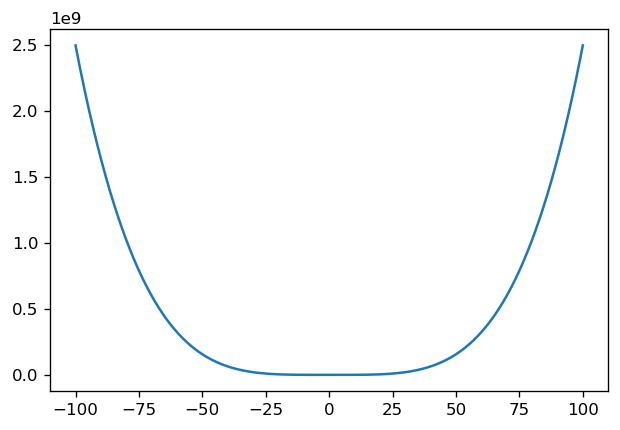

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, randint
def f(x,y):
    return 25*(y+x**2)**2+(1+x)**2

xlist = np.linspace(-100,100,num=1000)

ylist = f(xlist,0)

plt.figure(num=0,dpi=120)
plt.plot(xlist,ylist)

def gradient_descent(x,y):
    m_curr = b_curr = 0
    iterations = 1000
    n = len(x)
    learning_rate = 1
    
    for i in range(iterations):
        y_predicted = m_curr * x + b_curr
        md = -(2/n) * sum (x*(y-y_predicted))
        bd = -(2/n) * sum (y-y_predicted)
        m_curr = m_curr - learning_rate * md 
        b_curr = b_curr - learning_rate * bd 
        print("m {}, b {}, iteration {}".format(m_curr,b_curr, i))

x = np.array([1,2,3,4,5])
y = np.array([5,7,9,11,13])

In [ ]:
import numpy as np
import random
import collections
import operator
import itertools
from math import exp
import time
import warnings

N_ITER = 1500
populationSize = 4
precision = 3
Gd_x = Gd_y = -3
Gg_x = Gg_y = 3
p_recomb = 0.25     # probability of recombination
p_mut = 0.05        # probability of mutation

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def print(self):
        print("(", self.x,", ", self.y, ")")
    def get_binary_coded(self, n):
        return bin(self.x)[2:].zfill(n), bin(self.y)[2:].zfill(n)

def fun(x,y):
    # this is the two-variable function for which minimum and maximum will be found
    return 25*(y+x**2)**2+(1+x)**2 
    #3 * ((1-x)**2)*np.exp(-x**2-(y+1)**2) - 10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)- 1/3*np.exp(-(x+1)**2-y**2)

def get_bd(x, Gd, Gg, n):
    return int(np.floor(((x - Gd) / (Gg - Gd)) * (2**n - 1)))  # returns bd

def get_x_from_bd(bd, Gd, Gg, n):
    return Gd + (Gg - Gd) / (2**n - 1) * bd    # returns x

def get_number_of_bits(Gd, Gg, p):
    return int(np.ceil(np.log2((Gg - Gd) * 10**p + 1)))  # returns n

def generate_population(size):
    list = []
    for i in range(size):
        x = random.uniform(-3.0, 3.0)
        y = random.uniform(-3.0, 3.0)
        list.append(Point(x, y))
    return list
        
def get_bd_point(point, Gd, Gg, p):
    n = get_number_of_bits(Gd, Gg, p)
    bdx = get_bd(point.x, Gd, Gg, n)
    bdy = get_bd(point.y, Gd, Gg, n)
    return Point(bdx,bdy)

def get_point_from_bd(bd, Gd, Gg, n):
    x = get_x_from_bd(bd.x, Gd, Gg, n)
    y = get_x_from_bd(bd.y, Gd, Gg, n)
    return Point(x, y)

def get_min_point(population):
    min_point = population[0]
    for p in population:
        if fun(p.x, p.y) < fun(min_point.x, min_point.y):
            min_point = p
    return min_point

def get_max_point(population):
    max_point = population[0]
    for p in population:
        if fun(p.x, p.y) > fun(max_point.x, max_point.y):
            max_point = p
    return max_point


def ff_min(point, max_point):
    # fitness function for minimum
    return fun(max_point.x, max_point.y) - fun(point.x, point.y)


def ff_max(point, min_point):
    # fitness function for maximum
    return fun(point.x, point.y) - fun(min_point.x, min_point.y)

def tuples_chromosome_grade_max(population):
    # generates pairs of chromosome and its grade for whole population (max)
    t_list = []
    maxPoint = get_max_point(population)
    minPoint = get_min_point(population)
    for chrom in population:
        if ff_max(chrom, maxPoint) == 0:
            t_list.append((chrom, ff_max(chrom, minPoint)))
    for chrom in population:
        if ff_max(chrom, maxPoint) != 0:
            t_list.append((chrom, ff_max(chrom, minPoint)))
    return t_list

def tuples_chromosome_grade_min(population):
    # generates pairs of chromosome and its grade for whole population (min)
    t_list = []
    maxPoint = get_max_point(population)
    minPoint = get_min_point(population)
    for chrom in population:
        if ff_min(chrom, maxPoint) == 0:
            t_list.append((chrom, ff_min(chrom, maxPoint)))
    for chrom in population:
        if ff_min(chrom, maxPoint) != 0:
            t_list.append((chrom, ff_max(chrom, maxPoint)))
    return t_list

# TODO > combine these two functions above into one

def get_probs(grades):
    total = sum(grades)
    probs = []
    for g in grades:
        probs.append(g / total)
    return probs

def get_cumulative_grades(probabilities):
    cumulative_grades = []
    current = probabilities[0]
    cumulative_grades.append(current)
    for i in range(1, len(probabilities)):
        current = current + probabilities[i]
        cumulative_grades.append(current)

    return cumulative_grades

def roulette_selection(population, look_for):
    # use roulette selection to choose which chromosomes will recombinate
    if look_for == 'max':
        pairs = tuples_chromosome_grade_max(population)
    elif look_for == 'min':
        pairs = tuples_chromosome_grade_min(population)
    else:
        raise ValueError('Wrong parameter.')
    grades = [x[1] for x in pairs]
    probs = get_probs(grades)
    cumulative_grades = get_cumulative_grades(probs)
    
    selected = []
    for j in range(len(population)):
        r = random.uniform(0,1)
        i = 0
        while r > cumulative_grades[i]:
            i = i + 1
        selected.append(pairs[i])
    ret_sel = []
    for t in selected:
        ret_sel.append(t[0])
    return ret_sel

def shuffle(population):
    return random.shuffle(population)

def recombinate_pair(chrom1, chrom2):
    # recombinates two chromosomes in one point
    # since chromosome contains two points (x, y), x1, x2 and y1, y2 are recombinated in different points
    n = get_number_of_bits(Gd_x, Gg_x, precision)
    p1 = get_bd_point(chrom1, Gd_x, Gg_x, precision)
    p2 = get_bd_point(chrom2, Gd_x, Gg_x, precision)
    x1, y1 = p1.get_binary_coded(n)
    x2, y2 = p2.get_binary_coded(n)
    crossover_point = random.randint(0, n - 1)
    new_x1_bd = x1[:len(x1) - crossover_point - 1] + x2[len(x2) - crossover_point - 1:]
    new_x2_bd = x2[:len(x2) - crossover_point - 1] + x1[len(x1) - crossover_point - 1:]
    new_y1_bd = y1[:len(y1) - crossover_point - 1] + y2[len(y2) - crossover_point - 1:]
    new_y2_bd = y2[:len(y2) - crossover_point - 1] + y1[len(y1) - crossover_point - 1:]
    bd_point_1 = Point(int(new_x1_bd, 2), int(new_y1_bd, 2))
    bd_point_2 = Point(int(new_x2_bd, 2), int(new_y2_bd, 2))
    point_1 = get_point_from_bd(bd_point_1, Gd_x, Gg_x, n)
    point_2 = get_point_from_bd(bd_point_2, Gd_x, Gg_x, n)
    return point_1, point_2
    

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
    

def crossover(population):
    shuffle(population)
    recombinated_population = []
    pairs = list(chunks(population, 2))
    for pair in pairs:
        r = random.uniform(0, 1)
        if r < p_recomb:
            recombinated_population.append(recombinate_pair(pair[0], pair[1]))
        else:
            recombinated_population.append(pair)
    return list(itertools.chain(*recombinated_population))


def chromosome_mutation(chrom, n, mutation_point_x, mutation_point_y):
    # mutate one chromosome in one point
    bd_point = get_bd_point(chrom, Gd_x, Gg_x, precision)
    x_c, y_c = bd_point.get_binary_coded(n)
    x_coord = list(x_c)
    y_coord = list(y_c)
    if x_coord[- mutation_point_x - 1] == '0':
        x_coord[- mutation_point_x - 1] = '1'
    else:
        x_coord[- mutation_point_x - 1] = '0'
        
    if y_coord[- mutation_point_y - 1] == '0':
        y_coord[- mutation_point_y - 1] = '1'
    else:
        y_coord[- mutation_point_y - 1] = '0'
    
    x = int(''.join(x_coord), 2)
    y = int(''.join(y_coord), 2)
    return get_point_from_bd(Point(x, y), Gd_x, Gg_x, n)


def mutate(population):
    n = get_number_of_bits(Gd_x, Gg_x, precision)
    mutation_point_x = random.randint(0, n - 1)
    mutation_point_y = random.randint(0, n - 1)
    mutated_population = []
    for chrom in population:
        r = random.uniform(0, 1)
        if r < p_mut:
            mutated_population.append(chromosome_mutation(chrom, n, mutation_point_x, mutation_point_y))
        else:
            mutated_population.append(chrom)
    return mutated_population

def find_minimum():
    test_pop = generate_population(populationSize)

    for i in range(N_ITER):
        r_sel = roulette_selection(test_pop, look_for = 'min')
        crossed = crossover(r_sel)
        test_pop = mutate(crossed)

    min_point = test_pop[0]
    for t in test_pop:
        if fun(t.x, t.y) < fun(min_point.x, min_point.y):
            min_point = t
    return min_point


def find_maximum():
    test_pop = generate_population(populationSize)

    for i in range(N_ITER):
        r_sel = roulette_selection(test_pop, look_for = 'max')
        crossed = crossover(r_sel)
        test_pop = mutate(crossed)

    max_point = test_pop[0]
    for t in test_pop:
        if fun(t.x, t.y) > fun(max_point.x, max_point.y):
            max_point = t
    return max_point


def main():
    warnings.filterwarnings("ignore")
    print('Calculating...')
    # tms = time.time()

    print('Looking for minimum...')
    minimum_point = find_minimum()
    print('(', minimum_point.x, ',', minimum_point.y, ') ->', fun(minimum_point.x, minimum_point.y))
    print('Looking for maximum...')
    maximum_point = find_maximum()
    print('(', maximum_point.x, ',', maximum_point.y, ') ->', fun(maximum_point.x, maximum_point.y))

    # tme = time.time()
    
    # print(round(tme - tms, 2))

if __name__ == "__main__":
    main()

In [8]:
def f(x,y):
    return 25*(y+x**2)**2+(1+x)**2

def gradient_descent(x,y, inter, lr):
    m_curr = b_curr = 0
    iterations = inter
    n = len(x)
    learning_rate = lr

    for i in range(iterations):
        y_predicted = m_curr * x + b_curr
        md = -(2/n) * sum (x*(y-y_predicted))
        bd = -(2/n) * sum (y-y_predicted)
        m_curr = m_curr - learning_rate * md 
        b_curr = b_curr - learning_rate * bd 
        print("m {}, b {}, iteration {}".format(m_curr,b_curr, i))

x = np.array([1,2,3,4,5])
y = np.array([5,7,9,11,13])

gradient_descent(x,y, 1000,  1e-6)
gradient_descent(x,y, 1000,  0.1)
gradient_descent(x,y, 1000, 1)

gradient_descent(x,y, 100, 1e-6)
gradient_descent(x,y, 100, 0.1)
gradient_descent(x,y, 100, 1)

m 6.2e-05, b 1.8e-05, iteration 0
m 0.000123998528, b 3.5999592e-05, iteration 1
m 0.00018599558403483202, b 5.3998776009648e-05, iteration 2
m 0.0002479911681393272, b 7.199755203859177e-05, iteration 3
m 0.0003099852803483159, b 8.999592009647886e-05, iteration 4
m 0.00037197792069662767, b 0.00010799388019295657, iteration 5
m 0.0004339690892190912, b 0.000125991432337672, iteration 6
m 0.0004959587859505344, b 0.00014398857654027202, iteration 7
m 0.0005579470109257842, b 0.00016198531281040325, iteration 8
m 0.000619933764179667, b 0.00017998164115771206, iteration 9
m 0.0006819190457470081, b 0.00019797756159184467, iteration 10
m 0.0007439028556626321, b 0.000215973074122447, iteration 11
m 0.0008058851939613627, b 0.00023396817875916479, iteration 12
m 0.0008678660606780231, b 0.0002519628755116435, iteration 13
m 0.0009298454558474351, b 0.0002699571643895284, iteration 14
m 0.00099182337950442, b 0.00028795104540246455, iteration 15
m 0.0010537998316837984, b 0.00030594451856

m 0.059211095429845644, b 0.017199270044726322, iteration 965
m 0.059271689590125916, b 0.017216880379613653, iteration 966
m 0.05933228231167265, b 0.017234490315715355, iteration 967
m 0.059392873594519904, b 0.017252099853040853, iteration 968
m 0.059453463438701705, b 0.01726970899159958, iteration 969
m 0.059514051844252104, b 0.017287317731400964, iteration 970
m 0.059574638811205144, b 0.017304926072454437, iteration 971
m 0.05963522433959486, b 0.017322534014769426, iteration 972
m 0.0596958084294553, b 0.01734014155835536, iteration 973
m 0.0597563910808205, b 0.017357748703221664, iteration 974
m 0.059816972293724506, b 0.017375355449377773, iteration 975
m 0.05987755206820135, b 0.017392961796833112, iteration 976
m 0.05993813040428507, b 0.01741056774559711, iteration 977
m 0.0599987073020097, b 0.017428173295679195, iteration 978
m 0.06005928276140928, b 0.01744577844708879, iteration 979
m 0.06011985678251785, b 0.017463383199835328, iteration 980
m 0.06018042936536944, b

m -8.736276354998827e+90, b -2.4198084636928253e+90, iteration 667
m 1.193541670421429e+91, b 3.305919042045036e+90, iteration 668
m -1.6306051470284178e+91, b -4.516514788892547e+90, iteration 669
m 2.2277170637676545e+91, b 6.1704190510564715e+90, iteration 670
m -3.043485619584574e+91, b -8.429967141760751e+90, iteration 671
m 4.157980772007134e+91, b 1.1516940004098844e+91, iteration 672
m -5.680593326654492e+91, b -1.573433262876373e+91, iteration 673
m 7.760771949711215e+91, b 2.1496093856915974e+91, iteration 674
m -1.0602691971068417e+92, b -2.936775661273451e+91, iteration 675
m 1.4485295762046172e+92, b 4.0121946536222894e+91, iteration 676
m -1.9789671706628785e+92, b -5.4814217343298725e+91, iteration 677
m 2.7036459088552476e+92, b 7.488665636513374e+91, iteration 678
m -3.6936950288171e+92, b -1.0230942943920791e+92, iteration 679
m 5.046290611215768e+92, b 1.397741581776597e+92, iteration 680
m -6.894193682524878e+92, b -1.9095811013081834e+92, iteration 681
m 9.41878107

<ipython-input-8-d5ef03a7206d>:12: RuntimeWarning: overflow encountered in double_scalars
  md = -(2/n) * sum (x*(y-y_predicted))
<ipython-input-8-d5ef03a7206d>:14: RuntimeWarning: invalid value encountered in double_scalars
  m_curr = m_curr - learning_rate * md



m nan, b nan, iteration 479
m nan, b nan, iteration 480
m nan, b nan, iteration 481
m nan, b nan, iteration 482
m nan, b nan, iteration 483
m nan, b nan, iteration 484
m nan, b nan, iteration 485
m nan, b nan, iteration 486
m nan, b nan, iteration 487
m nan, b nan, iteration 488
m nan, b nan, iteration 489
m nan, b nan, iteration 490
m nan, b nan, iteration 491
m nan, b nan, iteration 492
m nan, b nan, iteration 493
m nan, b nan, iteration 494
m nan, b nan, iteration 495
m nan, b nan, iteration 496
m nan, b nan, iteration 497
m nan, b nan, iteration 498
m nan, b nan, iteration 499
m nan, b nan, iteration 500
m nan, b nan, iteration 501
m nan, b nan, iteration 502
m nan, b nan, iteration 503
m nan, b nan, iteration 504
m nan, b nan, iteration 505
m nan, b nan, iteration 506
m nan, b nan, iteration 507
m nan, b nan, iteration 508
m nan, b nan, iteration 509
m nan, b nan, iteration 510
m nan, b nan, iteration 511
m nan, b nan, iteration 512
m nan, b nan, iteration 513
m nan, b nan, itera